In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.CIFAR)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('train'),Path('labels.txt'),Path('test')]

In [ ]:
(path/"train").ls()

(#10) [Path('train/bird'),Path('train/automobile'),Path('train/truck'),Path('train/airplane'),Path('train/deer'),Path('train/dog'),Path('train/horse'),Path('train/frog'),Path('train/cat'),Path('train/ship')]

In [ ]:
(path/"train/bird").ls()

(#5000) [Path('train/bird/46261_bird.png'),Path('train/bird/14106_bird.png'),Path('train/bird/5535_bird.png'),Path('train/bird/15621_bird.png'),Path('train/bird/9579_bird.png'),Path('train/bird/19655_bird.png'),Path('train/bird/45639_bird.png'),Path('train/bird/29907_bird.png'),Path('train/bird/17832_bird.png'),Path('train/bird/5290_bird.png')...]

In [ ]:
fname = (path/"train/bird").ls()[0]

In [ ]:
fname

Path('train/bird/46261_bird.png')

In [ ]:
fname.name

'46261_bird.png'

In [ ]:
cifar10= DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y= parent_label,
                 batch_tfms=aug_transforms(size=224))

In [ ]:
dls = cifar10.dataloaders(path/"train")

### Checking and Debugging a DataBlock

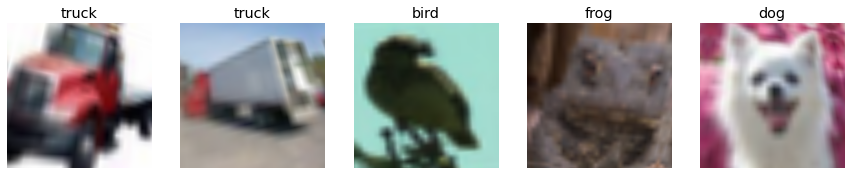

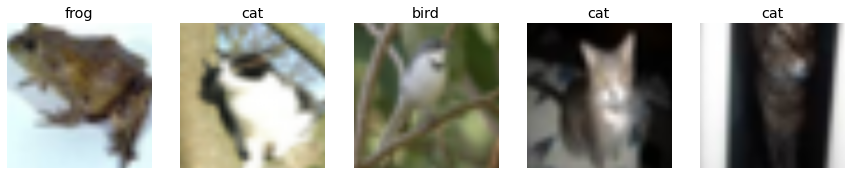

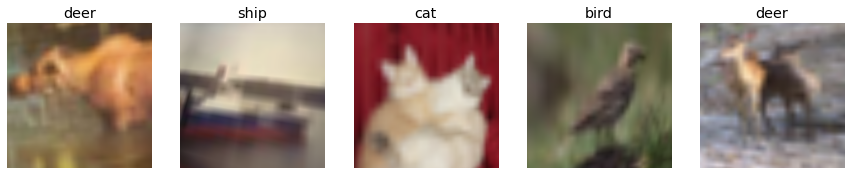

In [ ]:
dls.show_batch(nrows=1, ncols=5)
dls.valid.show_batch(nrows=1, ncols=5)
dls.train.show_batch(nrows=1, ncols=5)

In [ ]:
#hide_output
cifar10.summary(path/"train")

Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/harpreet/.fastai/data/cifar10/train/deer/17123_deer.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/harpreet/.fastai/data/cifar10/train/deer/17123_deer.png
    applying parent_label gives
      deer
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(4))


Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Set

```
Setting-up type transforms pipelines
Collecting items from /home/sgugger/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying partial gives
      american_bulldog
    applying Categorize gives
      TensorCategory(12)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(12))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(12))
    applying ToTensor gives
      (TensorImage of size 3x500x375, TensorCategory(12))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following 
shapes:
torch.Size([3, 500, 375]),torch.Size([3, 375, 500]),torch.Size([3, 333, 500]),
torch.Size([3, 375, 500])
```

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.671253,0.374649,0.124900,07:11


epoch,train_loss,valid_loss,error_rate,time
0,0.308569,0.207826,0.074400,16:13
1,0.168629,0.134124,0.046700,04:15


## Model Interpretation

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Oh dear—in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the `most_confused` method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [ ]:
interp.most_confused(min_val=5)

## Improving Our Model

### The Learning Rate Finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_steep = learn.lr_find()

In [ ]:
print(lr_steep.valley)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=lr_steep.valley)

### Unfreezing and Transfer Learning

In [ ]:
learn.fine_tune?

In [ ]:
learn.fit_one_cycle??

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

Then we'll unfreeze the model:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-05)

### Discriminative Learning Rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(1e-6,1e-4))

In [ ]:
learn.recorder.plot_loss()

### Deeper Architectures

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(10, freeze_epochs=3)

In [ ]:
learn.recorder.plot_loss()

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.